In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from blackmirror.models.RNN.data import *
from blackmirror.models.RNN.clf import *
from blackmirror.textutils import *

Using TensorFlow backend.


# Datasets

In [3]:
df = pd.read_csv('../data/wiki-train-v1.0.csv')
df.loc[:, 'normal'] = 0
df.loc[
 (df.toxic == 0) & \
 (df.severe_toxic == 0) & \
 (df.obscene == 0) & \
 (df.threat == 0) & \
 (df.insult == 0) & \
 (df.identity_hate == 0), 'normal'] = 1
df.shape

(159571, 9)

In [4]:
sentences_insults = build_sentences('\n'.join(df[df.normal != 1].comment_text))
sentences_normal = build_sentences('\n'.join(df[df.normal == 1].sample(len(sentences_insults)).comment_text))
tokenizers = create_tokenizers(' '.join(sentences_normal))

In [5]:
features = np.concatenate([
    build_sentence_features(sentences_insults, *tokenizers),
    build_sentence_features(sentences_normal, *tokenizers),
])
labels = np.concatenate([
    np.ones((len(sentences_insults), 1)),
    np.zeros((len(sentences_normal), 1)),
])
features.shape, labels.shape

((64430, 128), (64430, 1))

# Insult classifier

In [6]:
batch_size = 64

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    features,
    labels,
    shuffle=True
)

In [8]:
#X_train = X_train[:-(X_train.shape[0] % 64)]
#Y_train = Y_train[:-(Y_train.shape[0] % 64)]

In [9]:
clf = create_classifier(
    len(tokenizers[0]),
    batch_size=batch_size,
    rnn_units=32,
    embedding_dim=256
)
clf.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         16384     
_________________________________________________________________
gru (GRU)                    (None, 32)                27744     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 44,161
Trainable params: 44,161
Non-trainable params: 0
_________________________________________________________________


In [10]:
clf.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
history = clf.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_test, Y_test)
)

Train on 48322 samples, validate on 16108 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
48322/48322 [==============================] - 82s 2ms/sample - loss: 0.6762 - acc: 0.5781 - val_loss: 0.6162 - val_acc: 0.6790
Epoch 2/10
48322/48322 [==============================] - 75s 2ms/sample - loss: 0.5209 - acc: 0.7484 - val_loss: 0.4936 - val_acc: 0.7680
Epoch 3/10
48322/48322 [==============================] - 80s 2ms/sample - loss: 0.4649 - acc: 0.7822 - val_loss: 0.4622 - val_acc: 0.7811
Epoch 4/10
48322/48322 [==============================] - 83s 2ms/sample - loss: 0.4406 - acc: 0.7934 - val_loss: 0.4398 - val_acc: 0.7899
Epoch 5/10
48322/48322 [==============================] - 82s 2ms/sample - loss: 0.4264 - acc: 0.8029 - val_loss: 0.4386 - val_acc: 0.7940
Epoch 6/10
48322/48322 [==============================] - 80s 2ms/sample - loss: 0.4125 - acc: 0.8116 - val_loss: 0.4191 - val_acc: 0.8046
Epoch 7/10
48322/48322 [==============================] - 83s 2ms/sa

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

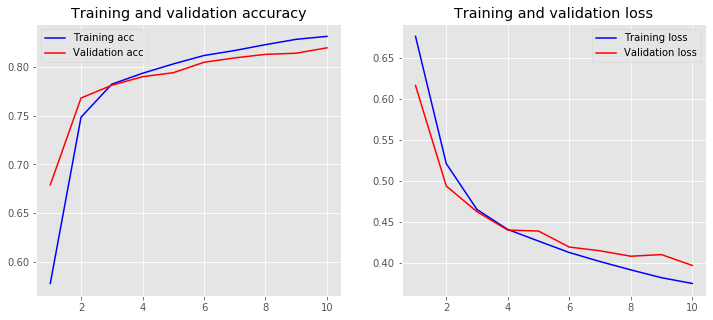

In [13]:
plot_history(history)

In [23]:
clf.predict(X_test[:10])

array([[0.06739229],
       [0.4549461 ],
       [0.03355372],
       [0.08168611],
       [0.11071074],
       [0.08131734],
       [0.07967222],
       [0.9884271 ],
       [0.41821107],
       [0.05658707]], dtype=float32)

In [15]:
''.join([tokenizers[1][c] for c in X_test[0]]).strip()

'are NPOV. Again, it is clear that you are not interested in factual accuracy in the article.'

In [16]:
''.join([tokenizers[1][c] for c in X_test[2]]).strip()

'The mission turning back to Rome is not explained. Is there a significance to what happened?'

In [17]:
import joblib
dialogues = joblib.load('../data/dialogues.bin')

In [18]:
responses = [ d[1] for d in dialogues ]
responses = build_sentences('\n'.join(responses).replace('\t', ' '))
responses_tokens = build_sentence_features(responses, *tokenizers)

In [19]:
%%time
scores = clf.predict(responses_tokens)

CPU times: user 5min 3s, sys: 53.5 s, total: 5min 56s
Wall time: 1min 59s


In [43]:
threshold = 0.99

In [44]:
responses_offensive = []
for idx in np.where(scores > threshold)[0]:
    responses_offensive.append(dialogues[idx])
len(responses_offensive)

3104

In [52]:
responses_offensive[1200]

['Whales, Scotty. 45 to 50 feet long; about 40 tons a piece.',
 'Admiral - how am I going to handle all that weight?']